## Matrix multiplication from foundations

이 코스는 다음 내용들을 다룰 것이다.

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Check imports

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=1850)

## Colab 사용자용

구글 드라이브에서 작업하려면 드라이브를 마운트하고, 팔요한 파일을 VM에 올려야한다.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# repo에 있는 exp 폴더를 불러오자.
# /content 에 파일을 두면 colab 에서 인식된다.
# 원본 파일 경로는 자신의 드라이브에 맞게 설정
!cp -r /gdrive/"My Drive"/develop/course-v3-master/course-v3-master/nbs/dl2/exp /content

## 여기서 부터 시작

In [0]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
test_eq(TEST,'test')

In [0]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

python3: can't open file 'run_notebook.py': [Errno 2] No such file or directory


## Get data

튜토리얼에 사용할 데이터를 가져오자. 

이번 코스에서는 MNIST를 사용

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path
# PosixPath('/root/.fastai/data/mnist.pkl.gz') 에 저장하였음

PosixPath('/root/.fastai/data/mnist.pkl.gz')

gzip 을 사용해서 gz 파일을 압출해제 하자.

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    # pickle 을 사용해서 시리얼라이즈된 MNIST 데이터를 가져옴

In [0]:
# 학습셋 5만개, 테스트셋 1만개
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

print(type(x_train)) # pickle을 사용했으므로 <class 'numpy.ndarray'> 을 바로 불러올수 있었다.

(50000, 784)
(50000,)
(10000, 784)
(10000,)
<class 'numpy.ndarray'>


map 을 이용해서 ndarray 를 모두 파이토치 텐서로 변경하자.

In [0]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max() # min, max 는 당연히 0~9 값을 가질것(레이블)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
# 데이터 확인해보기
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

print(type(x_train))

torch.Size([50000, 784])
torch.Size([50000])
torch.Size([10000, 784])
torch.Size([10000])
<class 'torch.Tensor'>


In [0]:
# 데이터 확인해보기
assert n==y_train.shape[0]==50000
test_eq(c,28*28)    # 28*28 크기의 이미지
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
img = x_train[0]

In [0]:
img.view(28,28).type()

'torch.FloatTensor'

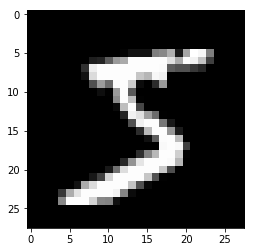

In [0]:
plt.imshow(img.view((28,28)));

## Initial python model

파이썬만 가지고 matmul을 구현해보자.

아래 모델은 input으로 784, output으로 10 이다.

(h = W * x + b) 즉, 가장 일반적인 선형회귀 모델

In [0]:
weights = torch.randn(784,10) 

In [0]:
bias = torch.zeros(10)

#### Matrix multiplication

In [0]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [0]:
m1 = x_valid[:5]    # 데이터 5개
m2 = weights        # 랜덤으로 초기화한 가중치

In [0]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [0]:
%time t1=matmul(m1, m2) # 5개의 이미지를 계산하는데 약 710ms 소요

CPU times: user 703 ms, sys: 0 ns, total: 703 ms
Wall time: 710 ms


In [0]:
t1.shape 

torch.Size([5, 10])

In [0]:
t1  # 이미지 1장 마다의 회귀결과 (학습X, 랜덤초기화) 
    # 아직 softmax 등의 activation function 을 지나지 않아서 값이 음수도 포함

tensor([[ 18.6984,  -0.5125,  -1.7549,  15.3637,   0.3643,   1.0121,  13.4340,
           8.0155,   2.8786,  -1.2003],
        [  9.8288,  -6.4187,   0.6157,  12.7299,  -1.5132,   1.3151,   8.7461,
           3.5137,   8.7100,   4.8288],
        [ 11.3930,   0.6689,  -3.6605,  14.5268,  -4.1145,  -7.8819,  -5.2918,
           3.0917,  15.8515,   9.9470],
        [ 19.0980,   1.3692, -10.2871,   6.7976,  -3.9947,  -9.2032, -10.0961,
           3.3106,   4.7240,  10.4961],
        [  6.5426,   5.4318,  -3.3914,   9.4414,   1.9684,  -8.3511,  -4.5946,
          10.7563,   3.6104,   4.7832]])

결과적으로 파이썬으로 구현한 matmul은 너무 느리다. 이제 파이썬 방법보다 5만배 빠르게 구현해보자.

#### Elementwise ops

파이토치(+넘파이)에서 (+,-,\*,/,>,<,==) 연산자들은 대부분 element-wise(모든 원소를 계산) 연산을 한다. 

예를들어:

In [0]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [0]:
a + b

tensor([12., 14.,  3.])

In [0]:
(a < b).float().mean()  # a 가 b 보다 작으면 1, 크면 0 
                        # 0.666 이므로 a가 b보다 작은 원소가 2개

tensor(0.6667)

In [0]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

위 식을 구현해보자.

In [0]:
(m*m).sum().sqrt() # 식 내부에 있는 시그마는 sum()으로 해결됨 element-wise

tensor(16.8819)

#### Elementwise matmul

이제 기존의 matmul을 개선해보자.

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # 루프 하나를 제거하고 element-wise 연산으로 대체하였다.
            # [i, :] = i번째 row, 전체 col
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum() 
    return c

In [0]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 1.05 ms per loop


기존의 705ms 가 걸리던 코드보다 대략 70배 빨라졌다.

In [0]:
890.1/5

178.02

In [0]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [0]:
test_near(t1,matmul(m1, m2))

### Broadcasting

**브로드케스팅** 이란 서로 다른 shape을 가진 array들이 산술 연산시 어떻게 다뤄지는지~ 이다. 넘파이에서 처음 소개되었으나, 이러한 컨셉은 1962년 APL에서 탄생하였다고 한다. (강의中)

브로드캐스팅을 사용하면 파이썬스러운 코드를 유지하면서 C, CUDA 속도의 성능을 낼 수 있다. (루프를 C,CUDA로 구현하므로)

넘파이 문서에는 다음과 같이 설명되어 있다. [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.

추가로 효율적인 브로드케스팅을 사용하면 개발자가 코드를 덜 적어도 되게 하고, 이는 에러를 만들 확률을 줄여준다.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=3110)

#### Broadcasting with a scalar

단순한 스칼라 값은 다음과 같이 다뤄진다

In [0]:
a

tensor([10.,  6., -4.])

In [0]:
a > 0 # a의 원소중 0보다 큰 원소는 1, 작은 원소는 0으로 리턴

tensor([1, 1, 0], dtype=torch.uint8)

이러한 결과는 > 연산이 브로드캐스트되어 a의 차원만큼 계산되기 때문이다.

In [0]:
a + 1

tensor([11.,  7., -3.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [0]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [0]:
m + c # 브로드캐스트되어 c가 3번 stack됨

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [0]:
c + m # 브로드캐스트되어 c가 3번 stack됨

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

위 연산들은 실제로 rows를 복사하지는 않는다, 다만 row를 3배 늘려 계산한 것 처럼 보인다. 실제로는 stride 를 사용한것. 

In [0]:
t = c.expand_as(m) # c가 m 이랑 연산될때 어떤 모양이되는지 알 수 있다.

In [0]:
t # 예상한것과 같이 row를 3개로 늘린 모양이다.

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [0]:
m + t # c + m 과 똑같은 결과

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [0]:
t.storage() # 실제로 c를 늘린것 처럼 보였던 t는 메모리를 3배로 복사하지 않았다.
            # 실제로는 c와 같은 원소만 저장하고, stride 해서 3배로 보여준것이다.

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [0]:
t.stride(), t.shape 

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).


In [0]:
c.unsqueeze(0) # dim = 0

tensor([[10., 20., 30.]])

In [0]:
c.unsqueeze(1) # dim = 1

tensor([[10.],
        [20.],
        [30.]])

In [0]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [0]:
print(c.shape)                  # 원래 [3]
print(c.unsqueeze(0).shape)     # 0으로 unsq 하면 [1,3] 즉, axis=0 에 1짜리 차원을 추가함
print(c.unsqueeze(1).shape)     # 1으로 unsq 하면 [3,1] 즉, axis=1 에 1짜리 차원을 추가함

torch.Size([3])
torch.Size([1, 3])
torch.Size([3, 1])


In [0]:
print(c.shape)                  # 위 셀과 같은 작업이다.
print(c[None].shape)            # unsq 하고 싶은 위치에 None 을 적어주면 된다.
print(c[:,None].shape)

torch.Size([3])
torch.Size([1, 3])
torch.Size([3, 1])


언제나 뒤에 후행으로 오는 `:` 는 생략해도 된다. ( c[None, :] == c[None] )

그리고 `...` 의 의미는 앞선 모든 차원을 의미한다.

그러므로 `:,` 이 들어가는 코드는 `...` 으로 변경가능하다.

( c[:,None] == c[...,None] )

In [0]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [0]:
print(c.expand_as(m))           
print(c[:,None].expand_as(m))   # unsq 하고 나서 m 과 브로드캐스팅하면 stride 방향이 다르다.

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])
tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])


In [0]:
print(t.stride())
print(c[:,None].expand_as(m).stride())

(0, 1)
(1, 0)


In [0]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [0]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

#### Matmul with broadcasting

브로드캐스팅을 이용하여 루프를 하나더 없애보자.

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        # c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i].unsqueeze(-1) * b).sum(dim=0) # -1 은 마지막 차원을 뜻함
    return c

In [0]:
%timeit -n 10 _=matmul(m1, m2) # ms 보다 µs 은 1000배 빠르다,

10 loops, best of 3: 228 µs per loop


In [0]:
885000/277 # 파이썬보다 3194배 빠르다.

3194.945848375451

In [0]:
test_near(t1, matmul(m1, m2))

#### Broadcasting Rules

In [0]:
c[None,:]

tensor([[10., 20., 30.]])

In [0]:
c[None,:].shape

torch.Size([1, 3])

In [0]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [0]:
c[:,None].shape

torch.Size([3, 1])

In [0]:
c[None,:] * c[:,None] # 이 연산은 순서를 바꿔도 똑같다. (matmul이 아니기 때문)

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [0]:
c[...,None] * c[None] # 위와 같은 연산

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [0]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

두개의 arrays/tensors 를 연산할때, Numpy/Pytorch 는 연산할 텐서의 shape 을 element-wise로 비교한다. 이 작업은 **뒤애오는(후행) 차원** 부터 시작한다. 두 차원들은 다음과 같은 경우에 호환 가능하다.

- 두 차원이 같다. 또는
- 둘 중 하나가 1이고, 이 경우 같은 크기로 만들기 위해 브로드캐스팅 된다.

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation

Einstein summation (`einsum`) 은 일반적인 방식으로 연산과 합계를 결합하는 간단한 표현이다.

넘파이 문서에는 다음과 같이 쓰여있다.

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

In [0]:
# c[i,j] += a[i,k] * b[k,j]
# [i,k] * [k,j] -> [i,j]
# ik,kj -> ij
# 위 식의 뜻은 [i,k] 크기의 인풋과, [k,j] 크기의 인풋을 주고, 결과로 [i,j] 크기의 아웃풋을 받는다.

# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): 
    return torch.einsum('ik,kj->ij', a, b)  # a,b를 각각 [i,k], [k,j] 크기의 인풋으로 넣는다.
                                            # 내부 식은 임의로 변경 가능 예를들어 bik,bkj->bij (배치 wise로 계산하기 위해)

In [0]:
print(m1.shape)
print(m2.shape)
print(matmul(m1, m2).shape)

torch.Size([5, 784])
torch.Size([784, 10])
torch.Size([5, 10])


In [0]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 111.75 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 30.6 µs per loop


In [0]:
885000/55 # 16000배 빨라졌다.

16090.90909090909

In [0]:
test_near(t1, matmul(m1, m2))

### pytorch op

파이토치에 구현되어 있는 matmul을 사용해보자.

In [0]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 127.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 5.91 µs per loop


In [0]:
# time comparison vs pure python:
885000/18 # 거의 5만배 빨라졌다.

49166.666666666664

In [0]:
t2 = m1@m2  # 더 유연한 방법.

In [0]:
test_near(t1, t2)

In [0]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))